# Assignment 8

Group No - 9

Name

Yash Jain - 001521876

Sneha Swaroop - 001572060

Necessary Libray import

In [22]:
import pandas_datareader as web
import datetime
import numpy as np
from scipy.optimize import newton
import seaborn as sns
import pandas as pd
from scipy.stats import gamma
import matplotlib.pylab as plt
from pymc3 import Model, Uniform, StudentT, Normal, Exponential
%matplotlib inline

Data is about wheather details of east boston

Removing columns that are not needed and also filling data in if any is missing in any columns.

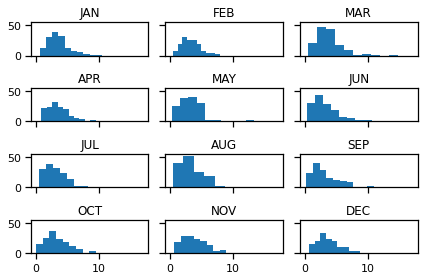

In [23]:
# Data importing
dell= pd.read_excel("Precipitation.xls")

# Data Cleansing
dell = dell[(dell['Basin Name'] == 'BOSTON HARBOR') & (dell['CITY'] == 'East Boston')]
dell = pd.DataFrame(dell, columns=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG','SEP','OCT','NOV','DEC'])
dell = dell[(dell['MAR'] != 0) & (dell['JUN'] != 0)]

for i in dell:
    dell.fillna(value={i: dell[i].mean()}, inplace=True)
    
# # Data exploration
import matplotlib.pyplot as plt
_ = dell.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

The first step is reconizing what sort of distribution to fit the data. 

**Observations:**
+ The data is *skewed*, with a longer tail to the right than to the left
+ The data is positive-valued, since they are measuring rainfall
+ The data is continuous

Even just by ***eyeballing*** the theoretical pdfs we introduced (normal, Poisson, etc.) , ***even if you did not know what the Gamma distribution is usually used for***, a good option appears to be the **gamma distribution**: The curves look like ***Gaussians with long tails***. That's a Gamma!

# Maximum Likelihood Estimation

Now let's put MLE to use with our Nashville rainfall data, where we used a gamma distribution instead of a Poisson distribution. So we need to maximize:

$$\prod_{i=1}^n \beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}$$ with respect to $(\alpha, \beta)$

In order to make the likelihood function more manageable (this is legit since `log` is monotonic with respect to its argument), the optimization is performed ***using a natural log transformation of the likelihood function***. In other words, we apply a **kernel method** transformation, which we learned about in our previous notebook. 

We are going to use the property that the *log of a product is the sum of the logs*:

$$ log(ab) = log(a) + log(b)$$

We want to maximize:

$$\begin{align}l(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

(*so much easier to work in the log scale because the log of a product is the sum of the logs!*)

where $n = 2012 − 1871 = 141$ and the bar indicates an average over all *i*. We want to choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

Notice $l$ is infinite if any $x$ is zero. We do not have any zeros, but we do have an NA value for one of the October data, which we dealt with.

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial l(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

Which can be solved as $\beta = \alpha\; / \; \bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} = 0$$

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest. In our case, this is:

In [24]:
from scipy.special import psi, polygamma

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively. `psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function.

In [25]:
# Calculate statistics
log_mean = dell.mean().apply(np.log)
mean_log = dell.apply(np.log).mean()
log_mean,mean_log

(JAN    1.269191
 FEB    1.205259
 MAR    1.369535
 APR    1.285189
 MAY    1.200007
 JUN    1.205169
 JUL    1.143348
 AUG    1.274792
 SEP    1.172526
 OCT    1.225989
 NOV    1.353054
 DEC    1.317767
 dtype: float64,
 JAN    1.149191
 FEB    1.092408
 MAR    1.237209
 APR    1.167254
 MAY    1.026301
 JUN    0.974808
 JUL    0.979524
 AUG    1.082628
 SEP    0.920519
 OCT    1.016465
 NOV    1.181029
 DEC    1.185430
 dtype: float64)

In [26]:
# Alpha MLE for Close
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

3.9371809685603263

And now plug this back into the solution for beta:

$$ \beta  = \frac{\alpha}{\bar{X}} $$

In [27]:
beta_mle = alpha_mle/dell.mean()[-1]
beta_mle

1.0541115757297912

# Method of Moment

$$f(x) = \frac{\beta^\alpha x^{\alpha -1} e^{- \beta x}}{\Gamma (\alpha)}$$

where, 
+ $\Gamma (\alpha)$ is the gamma function. For all positive integers, $\Gamma (\alpha)$ = $\Gamma (\alpha - 1)$!
+ $\alpha, \beta > 0$
+ $x > 0$

We can compare the fit of the estimates derived from MLE to those from our method of moments (MOM):

In [28]:
dell_mean, dell_var = dell.mean(), dell.var()

alpha_mom, beta_mom = dell_mean ** 2 / dell_var, dell_var / dell_mean

Let's plot both models and compare:

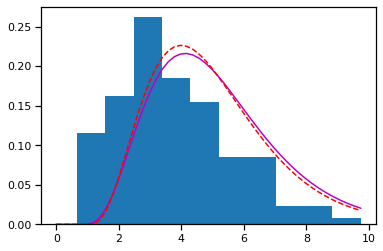

In [29]:
from scipy.stats.distributions import gamma

dell.DEC.hist(density=True, bins=10, grid=False)
x = np.linspace(0, dell.DEC.max())
plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'm-')
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')

Defined function to call mle alpha and beta values for each and every columns

In [30]:
def calculatemleGamma(m):
    alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[m], mean_log[m]))
    beta_mle = alpha_mle/dell.mean()[m]
    return alpha_mle, beta_mle

4.3263469941416
4.590745275857491
3.937497043764456
4.399416255693967
3.0348701090737458
2.3235291578739243
3.20910250574036
2.7572614116410787
2.135803700458529
2.5406338859120954
3.0630970910316804
3.9371809685603263


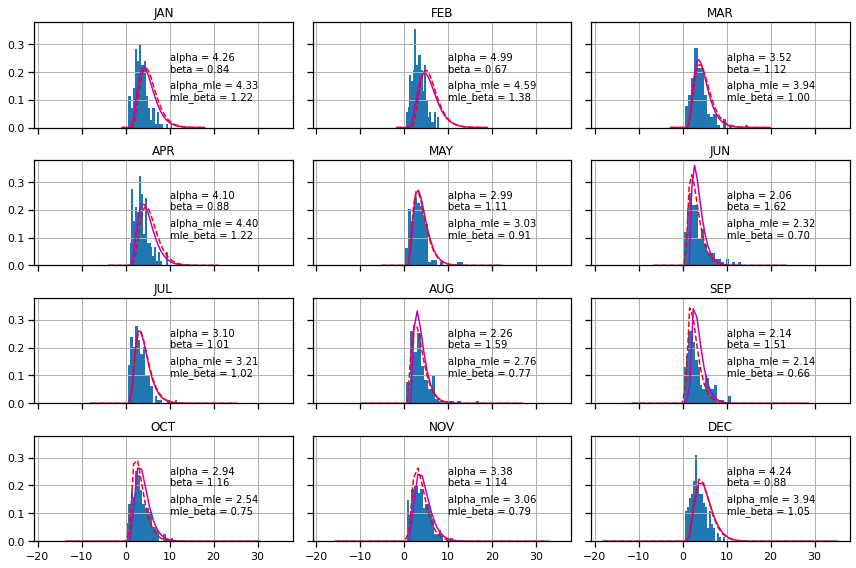

In [31]:
axs = dell.hist(density=True, figsize=(12, 8), sharex=True, sharey=True, bins=20, grid=True)

for ax in axs.ravel():
    # Get header
    m = ax.get_title()
    results = calculatemleGamma(m)
    print(results[0])
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]), 'm-', label='MOM')
    ax.plot(x, gamma.pdf(x, results[0], results[1]), 'r--', label='MLE')
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    label1 = 'alpha_mle = {0:.2f}\nmle_beta = {1:.2f}'.format(results[0], results[1])
    ax.annotate(label, xy=(10, 0.2))
    ax.annotate(label1, xy=(10, 0.1))
plt.tight_layout()

For `DEC` curve seems to fit better in the model as compared to rest of the parametes

In [32]:
gamma.fit(dell.DEC)

(4.669286337797242, -0.26999084720776834, 0.857744863353513)

# Experimenting with Programming and PYMC3

Define model in name of rainfall_model

+ First Parameter is the random mean and SD
+ Second Paramter is the random lower and upper bound
+ Third Parameter is exponential distribution 

In [33]:
sns.set_context('notebook')

RANDOM_SEED = 20090425

with Model() as rainfall_model:
    μ_0 = Normal('μ_0', 4, sd=2)
    μ_1 = Normal('μ_1', 4, sd=2)

In [34]:
with rainfall_model:
    σ_0 = Uniform('σ_0', lower=0, upper=4)
    σ_1 = Uniform('σ_1', lower=0, upper=4)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


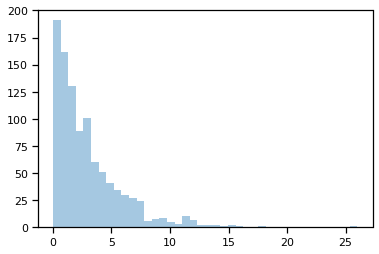

In [35]:
sns.distplot(Exponential.dist(1/3).random(size=1000), kde=False);

In [36]:
with rainfall_model:
    ν = Exponential('ν_minus_one', 1/3) + 1

In [37]:
with rainfall_model:
    JAN = StudentT('JAN', nu=ν, mu=μ_0, lam=σ_0**-2, observed=dell.JAN)
    DEC = StudentT('DEC', nu=ν, mu=μ_1, lam=σ_1**-2, observed=dell.DEC)


We need to specify Deterministic because all PyMC3 variables are by default probabilistic, unless we set them to be deterministic.

In [38]:
from pymc3 import Deterministic
    
with rainfall_model:
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    effect_size = Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

This will estimate all our posterior distributions using an optimized approximation, and then draw 10,000 samples from it.

In [39]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 576.85


Now plot all your posterior distributions, throwing away the first 100 samples. You typically always throw away from 10% to 20% of your simulation samples, because they start off wrong before converging to the right solution

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


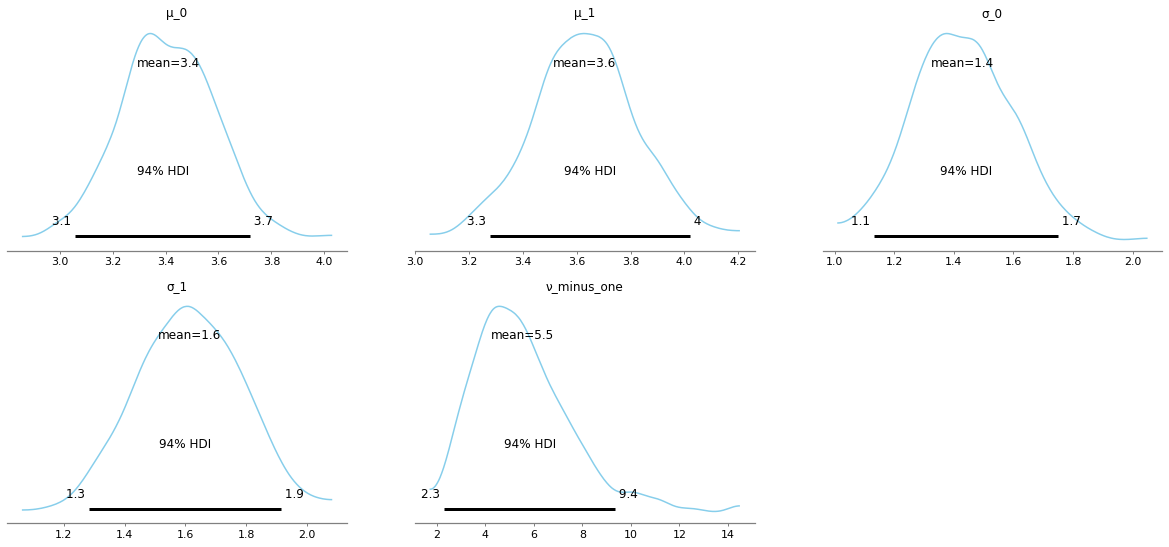

In [40]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                var_names=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'],
                color='#87ceeb');

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


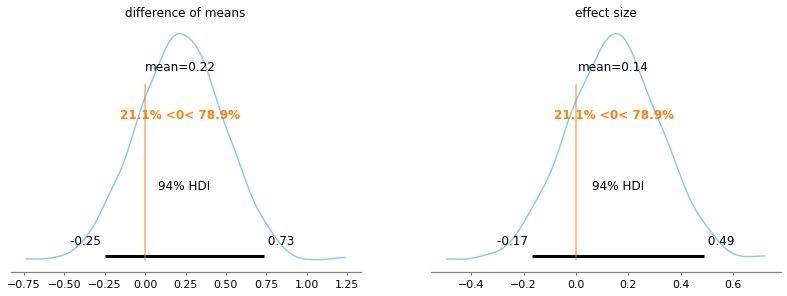

In [41]:
plot_posterior(rainfall_trace[100:], 
          var_names=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');

Conclusion: 

The posterior probability that the mean december rainfall is more than the january rainfall - minimal to the left of zero. That means that all the probability that the december is concentrated beyond the null hypothesis (0).